# Imports

In [1]:
from datetime import datetime
from fancyimpute import IterativeImputer
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fclusterdata

import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sqlite3

import umap

In [2]:
# Checking if the file 'olist.db' exists in the current directory
if not os.path.isfile('olist.db'):
    # If the file is not found, print an error message and exit the program
    print("Le fichier olist.db n'a pas été trouvé dans le répertoire courant.")
    exit()

# Connecting to the SQLite database 'olist.db'
conn = sqlite3.connect('olist.db')

# Creating a cursor object for executing SQL commands
cursor = conn.cursor()

In [3]:
# Write the SQL query 

query = """
WITH order_items_count AS (
  SELECT
    order_id,
    COUNT(*) AS nb_articles,
    COUNT(DISTINCT product_id) AS nb_categories,
    AVG(freight_value) AS avg_freight_value
  FROM
    order_items
  GROUP BY
    order_id
), customer_averages AS (
  SELECT
    o.customer_id,
    AVG(oic.nb_articles) AS nb_articles_moyen_par_commande,
    AVG(oic.nb_categories) AS nb_categories_moyen_par_commande,
    AVG(oic.avg_freight_value) AS avg_freight_value
  FROM
    orders o
  JOIN
    order_items_count oic ON o.order_id = oic.order_id
  GROUP BY
    o.customer_id
), payment_counts AS (
  SELECT
    order_id,
    payment_type,
    COUNT(*) AS count
  FROM
    order_pymts
  GROUP BY
    order_id,
    payment_type
), major_payment AS (
  SELECT
    order_id,
    payment_type AS mode_de_paiement_majoritaire
  FROM
    payment_counts
  WHERE
    (order_id, count) IN (
      SELECT
        order_id,
        MAX(count)
      FROM
        payment_counts
      GROUP BY
        order_id
    )
), payment_modes AS (
  SELECT
    o.customer_id,
    COUNT(DISTINCT op.payment_type) AS nb_mode_paiement
  FROM
    orders o
  JOIN
    order_pymts op ON o.order_id = op.order_id
  GROUP BY
    o.customer_id
)
SELECT
  c.customer_unique_id,
  (JULIANDAY('2018-10-17') - JULIANDAY(MIN(o.order_purchase_timestamp))) AS seniority,
  COUNT(or_reviews.order_id) AS nb_reviews,
  AVG(or_reviews.review_score) AS average_review_score,
  COUNT(o.order_id) AS nb_orders,
  AVG(oi.price) AS average_basket,
  SUM(CASE WHEN o.order_status = 'canceled' THEN 1 ELSE 0 END) AS nb_canceled,
  ca.nb_articles_moyen_par_commande,
  ca.nb_categories_moyen_par_commande,
  c.customer_state,
  mp.mode_de_paiement_majoritaire,
  pm.nb_mode_paiement,
  ca.avg_freight_value
FROM
  customers c
JOIN
  orders o ON c.customer_id = o.customer_id
LEFT JOIN
  order_reviews or_reviews ON o.order_id = or_reviews.order_id
JOIN
  order_items oi ON o.order_id = oi.order_id
JOIN
  customer_averages ca ON c.customer_id = ca.customer_id
LEFT JOIN
  major_payment mp ON o.order_id = mp.order_id
JOIN
  payment_modes pm ON c.customer_id = pm.customer_id
GROUP BY
  c.customer_unique_id
"""

In [4]:
# Execute the query and fetch the results as a pandas dataframe
data = pd.read_sql_query(query, conn)

In [5]:
# Close the connection
conn.close()

In [6]:
data

,customer_unique_id,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,customer_state,mode_de_paiement_majoritaire,nb_mode_paiement,avg_freight_value
0,0000366f3b9a7992bf8c76cfdf3221e2,159.544132,1,5.0,1,129.90,0,1.0,1.0,SP,credit_card,1,12.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162.533715,1,4.0,1,18.90,0,1.0,1.0,SP,credit_card,1,8.29
2,0000f46a3911fa3c0805444483337064,585.121493,1,3.0,1,69.00,0,1.0,1.0,SC,credit_card,1,17.22
3,0000f6ccb0745a6a4b88665a16c9f078,369.146053,1,4.0,1,25.99,0,1.0,1.0,PA,credit_card,1,17.63
4,0004aac84e0df4da2b147fca70cf8255,336.176597,1,5.0,1,180.00,0,1.0,1.0,SP,credit_card,1,16.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,495.124583,2,5.0,2,785.00,0,2.0,2.0,PE,credit_card,1,248.71
95415,fffea47cd6d3cc0a88bd621562a9d061,310.161157,1,4.0,1,64.89,0,1.0,1.0,BA,credit_card,1,19.69
95416,ffff371b4d645b6ecea244b27531430a,616.340787,1,5.0,1,89.90,0,1.0,1.0,MT,credit_card,1,22.56
95417,ffff5962728ec6157033ef9805bacc48,167.362720,1,5.0,1,115.00,0,1.0,1.0,ES,credit_card,1,18.69


# Transformation

In [7]:
raw_df = data.copy()

## Feature creation

### Total spent

In [9]:
raw_df['total_spent'] = raw_df['nb_orders']*raw_df['average_basket']

### Distance from warehouse

Difficulté à avoir une variable de localisation, trop de villes différentes
=> Création d'une variable de distance avec l'entrepôt

In [10]:
distances = {
    'SP': 350,  # São Paulo
    'SC': 250,  # Santa Catarina
    'PA': 3000, # Pará
    'PR': 0,    # Paraná (Curitiba is the capital)
    'RJ': 1000, # Rio de Janeiro
    'MA': 3500, # Maranhão
    'ES': 1200, # Espírito Santo
    'RS': 500,  # Rio Grande do Sul
    'MG': 1000, # Minas Gerais
    'GO': 1200, # Goiás
    'DF': 1500, # Distrito Federal
    'BA': 2500, # Bahia
    'MT': 2000, # Mato Grosso
    'SE': 2500, # Sergipe
    'TO': 3000, # Tocantins
    'PE': 3500, # Pernambuco
    'CE': 4000, # Ceará
    'AL': 3500, # Alagoas
    'AC': 4000, # Acre
    'PI': 3500, # Piauí
    'PB': 3000, # Paraíba
    'RN': 3000, # Rio Grande do Norte
    'AM': 4000, # Amazonas
    'MS': 1000, # Mato Grosso do Sul
    'RR': 4500, # Roraima
    'AP': 4500, # Amapá
    'RO': 4000, # Rondônia
}

In [11]:
raw_df['distance_to_warehouse'] = raw_df['customer_state'].map(distances)

### Number of reviews binary

In [12]:
# df['nb_reviews_binary'] = np.where(df['nb_reviews'] > 1, 2, 1)

## Imputation

In [13]:
imputed_df = raw_df.copy()

#### Imputation 1 : score médian
risque d'un amat de point sur ce score moyen

In [14]:
imputed_df['average_review_score'].fillna(3, inplace=True)

#### Imputation 2 : probabiliste
pas d'amat et pas de biais

In [15]:
#numeric_features = imputed_df.select_dtypes(exclude='object').columns
#non_numeric_features = imputed_df.select_dtypes(include='object').columns

In [16]:
#imp = IterativeImputer(max_iter=10, random_state=42)
#df_numeric_imputed = pd.DataFrame(imp.fit_transform(imputed_df[numeric_features]), columns=numeric_features)

In [17]:
#df_non_numeric_imputed = imputed_df[non_numeric_features]

In [18]:
#imputed_df = pd.concat([df_numeric_imputed, df_non_numeric_imputed], axis=1)

Je choisi la méthode 1

In [19]:
imputed_df.describe()

,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,nb_mode_paiement,avg_freight_value,total_spent,distance_to_warehouse
count,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000
mean,289.543047,1.199174,4.094158,1.209266,126.516998,0.005869,1.139333,1.036942,1.022333,20.221852,145.574848,895.868223
std,153.648324,0.679664,1.325222,0.679152,191.743000,0.098337,0.533603,0.222900,0.147765,15.868839,224.658115,913.327586
min,48.374572,0.000000,1.000000,1.000000,0.850000,0.000000,1.000000,1.000000,1.000000,0.000000,0.850000,0.000000
25%,165.328206,1.000000,4.000000,1.000000,42.900000,0.000000,1.000000,1.000000,1.000000,13.370000,48.900000,350.000000
50%,270.557350,1.000000,5.000000,1.000000,79.165000,0.000000,1.000000,1.000000,1.000000,16.380000,89.900000,350.000000
75%,399.422014,1.000000,5.000000,1.000000,139.900000,0.000000,1.000000,1.000000,1.000000,21.190000,159.000000,1000.000000
max,772.114363,24.000000,5.000000,24.000000,6735.000000,6.000000,21.000000,8.000000,2.000000,409.680000,13440.000000,4500.000000


In [20]:
imputed_df[(imputed_df.nb_orders>3)]

,customer_unique_id,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,customer_state,mode_de_paiement_majoritaire,nb_mode_paiement,avg_freight_value,total_spent,distance_to_warehouse
22,000fbf0473c10fc1ab6f8d2d286ce20c,82.594537,4,5.0,4,71.450000,0,4.0,2.0,SP,boleto,1,19.140000,285.80,350
157,0064a1b5f5cddd047c987b988a90c8c1,228.643380,4,5.0,4,53.900000,0,4.0,1.0,SP,boleto,1,13.400000,215.60,350
224,0096c18412349537abc45e350581cbbc,581.268426,4,1.0,4,169.900000,0,4.0,1.0,RS,credit_card,1,22.660000,679.60,500
229,0097fca0db567f5ca79509b7b4fc1c2d,180.529225,7,1.0,7,24.591429,0,7.0,4.0,SP,credit_card,1,7.931429,172.14,350
260,00ae50eb5e1d2514f694dee1dcbbd5ae,159.070104,5,1.0,5,42.700000,0,5.0,2.0,SP,credit_card,1,12.526000,213.50,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95134,ff44401d0d8f5b9c54a47374eb48c1b8,515.110486,4,3.0,4,19.900000,0,1.0,1.0,SP,credit_card,2,14.100000,79.60,350
95177,ff5f29fbfd0a13f7e7ed9f7b92a32194,446.496678,4,5.0,4,94.900000,0,4.0,3.0,RJ,credit_card,1,15.415000,379.60,1000
95229,ff7f36f6ba0f1126bb95b635322cf9d2,185.636632,6,3.0,6,29.990000,0,6.0,1.0,SP,credit_card,1,18.230000,179.94,350
95321,ffbb6557e45f7158781514f0efddb0d5,326.966574,4,4.0,4,22.900000,0,4.0,1.0,SP,credit_card,1,9.340000,91.60,350


## Transformation des types de colonne

In [21]:
transformed_df = imputed_df.copy()

In [22]:
transformed_df.dtypes

customer_unique_id                   object
seniority                           float64
nb_reviews                            int64
average_review_score                float64
nb_orders                             int64
average_basket                      float64
nb_canceled                           int64
nb_articles_moyen_par_commande      float64
nb_categories_moyen_par_commande    float64
customer_state                       object
mode_de_paiement_majoritaire         object
nb_mode_paiement                      int64
avg_freight_value                   float64
total_spent                         float64
distance_to_warehouse                 int64
dtype: object

In [23]:
# Convertir les colonnes float en float32
transformed_df[['seniority', 'average_review_score', 'nb_articles_moyen_par_commande', 'nb_categories_moyen_par_commande', 'average_basket', 'total_spent', 'avg_freight_value']] = transformed_df[['seniority', 'average_review_score', 'nb_articles_moyen_par_commande', 'nb_categories_moyen_par_commande', 'average_basket', 'total_spent', 'avg_freight_value']].astype('float32')

# Convertir les colonnes int en int16
transformed_df[['nb_reviews', 'nb_orders', 'nb_mode_paiement', 'nb_canceled', 'distance_to_warehouse']] = transformed_df[['nb_reviews', 'nb_orders', 'nb_mode_paiement', 'nb_canceled', 'distance_to_warehouse']].astype('int16')

In [24]:
transformed_df.dtypes

customer_unique_id                   object
seniority                           float32
nb_reviews                            int16
average_review_score                float32
nb_orders                             int16
average_basket                      float32
nb_canceled                           int16
nb_articles_moyen_par_commande      float32
nb_categories_moyen_par_commande    float32
customer_state                       object
mode_de_paiement_majoritaire         object
nb_mode_paiement                      int16
avg_freight_value                   float32
total_spent                         float32
distance_to_warehouse                 int16
dtype: object

## Scaler

In [29]:
scaled_df = transformed_df.copy()

In [30]:
# Scale the features using StandardScaler
#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled_df[scaled_df.select_dtypes(exclude='object').columns] = scaler.fit_transform(scaled_df.select_dtypes(exclude='object'))

Le scaler minmax ne donne pas un clustering pertinent car il exclu les variables monétaires. Il n'utilise que l'ancienneté, le nombre de commandes annulées et le score moyen.  
Ce n'est pas pertinent pour ce clustering.  
Je décide de faire le scaling avec un StandardScaler

In [31]:
scaler = StandardScaler()
scaled_df[scaled_df.select_dtypes(exclude='object').columns] = scaler.fit_transform(scaled_df.select_dtypes(exclude='object'))

In [32]:
# Encodage One-Hot
scaled_df = pd.get_dummies(scaled_df, columns=['customer_state', 'mode_de_paiement_majoritaire'])
scaled_df.describe()

,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,nb_mode_paiement,avg_freight_value,total_spent,distance_to_warehouse
count,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04
mean,-7.995676e-10,-6.156671e-09,-8.115611e-09,3.582063e-08,-2.638573e-09,-4.437601e-09,2.778498e-08,1.539168e-08,2.726526e-08,1.918962e-09,3.837925e-09,-4.497568e-09
std,9.999971e-01,1.000044e+00,1.000381e+00,9.997776e-01,9.999835e-01,9.995531e-01,1.000045e+00,1.000520e+00,1.000221e+00,9.999992e-01,1.000013e+00,1.000071e+00
min,-1.569622e+00,-1.764372e+00,-2.334834e+00,-3.081305e-01,-6.553963e-01,-5.968115e-02,-2.611184e-01,-1.657360e-01,-1.511398e-01,-1.274319e+00,-6.442038e-01,-9.808889e-01
25%,-8.084402e-01,-2.930495e-01,-7.105139e-02,-3.081305e-01,-4.360912e-01,-5.968115e-02,-2.611184e-01,-1.657360e-01,-1.511398e-01,-4.317826e-01,-4.303221e-01,-5.976728e-01
50%,-1.235666e-01,-2.930495e-01,6.835429e-01,-3.081305e-01,-2.469568e-01,-5.968115e-02,-2.611184e-01,-1.657360e-01,-1.511398e-01,-2.421017e-01,-2.478216e-01,-5.976728e-01
75%,7.151366e-01,-2.930495e-01,6.835429e-01,-3.081305e-01,6.979689e-02,-5.968115e-02,-2.611184e-01,-1.657360e-01,-1.511398e-01,6.100973e-02,5.975846e-02,1.140142e-01
max,3.140769e+00,3.354737e+01,6.835429e-01,3.355779e+01,3.446550e+01,6.095513e+01,3.722013e+01,3.123867e+01,6.616391e+00,2.454245e+01,5.917656e+01,3.946175e+00


In [33]:
scaled_df.dtypes

customer_unique_id                           object
seniority                                   float32
nb_reviews                                  float32
average_review_score                        float32
nb_orders                                   float32
average_basket                              float32
nb_canceled                                 float32
nb_articles_moyen_par_commande              float32
nb_categories_moyen_par_commande            float32
nb_mode_paiement                            float32
avg_freight_value                           float32
total_spent                                 float32
distance_to_warehouse                       float32
customer_state_AC                              bool
customer_state_AL                              bool
customer_state_AM                              bool
customer_state_AP                              bool
customer_state_BA                              bool
customer_state_CE                              bool
customer_sta

# Features selection

In [34]:
# Select the features to be used for clustering
features_v1 = ['nb_orders', 'average_review_score', 'seniority', 'average_basket', 'nb_canceled', 'total_spent', "nb_reviews"]

# Modélisation

In [35]:
df = scaled_df.copy()

In [36]:
df[features_v1].describe()

,nb_orders,average_review_score,seniority,average_basket,nb_canceled,total_spent,nb_reviews
count,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04,9.541900e+04
mean,3.582063e-08,-8.115611e-09,-7.995676e-10,-2.638573e-09,-4.437601e-09,3.837925e-09,-6.156671e-09
std,9.997776e-01,1.000381e+00,9.999971e-01,9.999835e-01,9.995531e-01,1.000013e+00,1.000044e+00
min,-3.081305e-01,-2.334834e+00,-1.569622e+00,-6.553963e-01,-5.968115e-02,-6.442038e-01,-1.764372e+00
25%,-3.081305e-01,-7.105139e-02,-8.084402e-01,-4.360912e-01,-5.968115e-02,-4.303221e-01,-2.930495e-01
50%,-3.081305e-01,6.835429e-01,-1.235666e-01,-2.469568e-01,-5.968115e-02,-2.478216e-01,-2.930495e-01
75%,-3.081305e-01,6.835429e-01,7.151366e-01,6.979689e-02,-5.968115e-02,5.975846e-02,-2.930495e-01
max,3.355779e+01,6.835429e-01,3.140769e+00,3.446550e+01,6.095513e+01,5.917656e+01,3.354737e+01


## Kmeans v1

### Entraînement

Choisir le nombre de clusters qui me semble pertinent d'un point de vue métier et le vérifier avec une ACP et la méthode du coude.

Bons clients et mauvais clients -> 2 clusters minimum


#### Choix des features

In [37]:
features = features_v1

#### Sélection du nombre de clusters

In [39]:
# Définir le nombre maximum de clusters à tester
n_clusters_max = 6

# Calculer les métriques pour chaque nombre de clusters
silhouette_scores = []
inertias = []
ch_scores = []

for i in range(2, n_clusters_max+1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df[features])

    # Silhouette Score
    silhouette_avg = silhouette_score(df[features], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Inertia
    inertias.append(kmeans.inertia_)

    # Calinski-Harabasz Score (variation inter-classe/intra-classe)
    ch_scores.append(calinski_harabasz_score(df[features], kmeans.labels_))

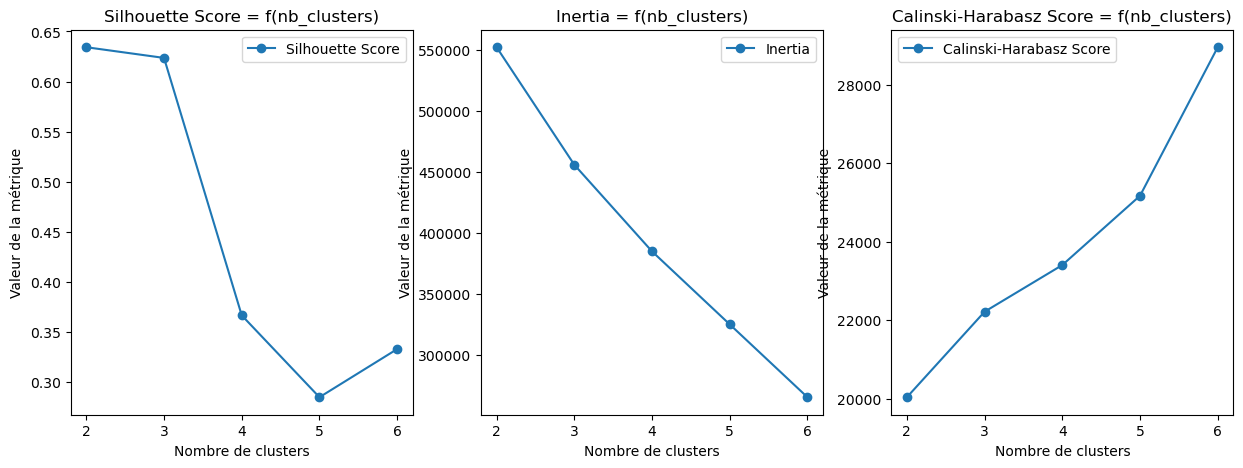

In [40]:
# Métriques et labels
metrics = [silhouette_scores, inertias, ch_scores]
labels = ['Silhouette Score', 'Inertia', 'Calinski-Harabasz Score']

# Créer une grille de sous-graphiques (1 ligne, 3 colonnes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Parcourir les métriques et les tracer côte à côte
for i, (metric, label, ax) in enumerate(zip(metrics, labels, axs)):
    ax.plot(range(2, n_clusters_max+1), metric, marker='o', label=label)
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Valeur de la métrique')
    ax.set_title(f'{label} = f(nb_clusters)')
    ax.legend()

plt.show()

<ins>Interprétation :</ins>  
Silhouette score doit être le plus élevé possible (appartenance d'un point à son cluster)  
Inerti doit être là où il y a un coude  
Calinski-Harabasz doit être le plus haut possible (ratio variance inter/intra cluster)
    
On choisi 4 clusters car il n'y a pas de coude dans l'inertie et on observe un score équilibré entre silhouette et CH.  
D'un point de vu métier, c'est pertinent de distinguer les clients en 4 catégories.

#### Entraînement final du modèle

In [41]:
# Select the number of clusters
n_clusters = 4

In [42]:
# Initialize the KMeans algorithm with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10)

# Fit the KMeans algorithm to the data
kmeans.fit(df[features])

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_
raw_df['cluster'] = kmeans.labels_

# Calculate metrics
silhouette_avg = silhouette_score(df[features], df['cluster'])
inertia = kmeans.inertia_
ch_score = calinski_harabasz_score(df[features], df['cluster'])

# Print metrics
print(f'Silhouette Score: {silhouette_avg}') # > 0.5 = bon ; > 0.25 = ok ; < 0.25 = mauvais
print(f'Inertia: {inertia}') # Une valeur faible indique que les points dans chaque cluster sont proches les uns des autres (et donc que le clustering est efficace)
print(f'Calinski-Harabasz Score: {ch_score}') # Une valeur élevée indique que la variance entre les clusters est maximisée par rapport à la variance à l'intérieur des clusters, ce qui signifie que les clusters sont bien définis et distincts

Silhouette Score: 0.3655449450016022
Inertia: 384952.0625
Calinski-Harabasz Score: 23380.31219862


###  Evaluation

#### Nombre d'individus par cluster

In [43]:
df.groupby('cluster')['customer_unique_id'].count()

cluster
0    69575
1     3250
2    20297
3     2297
Name: customer_unique_id, dtype: int64

#### Ecart types et moyennes pour chaque variable

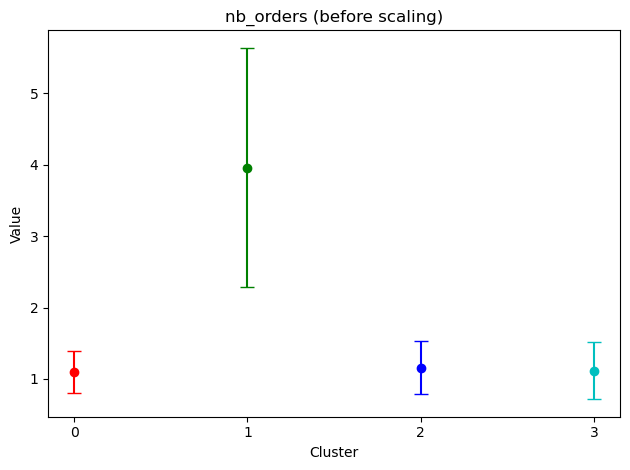

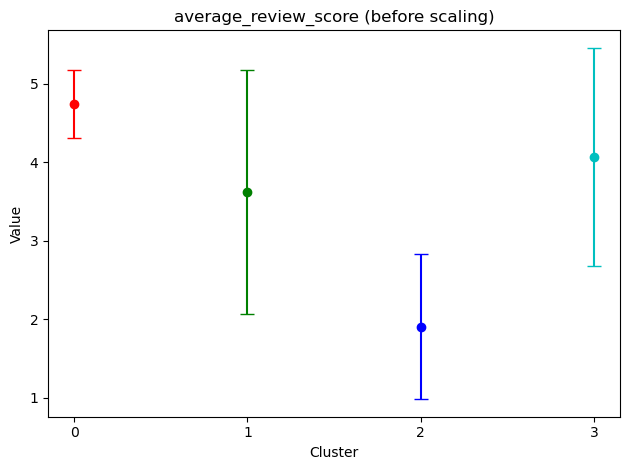

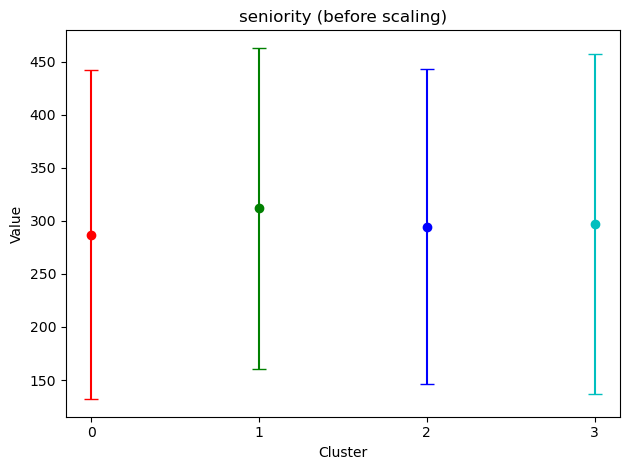

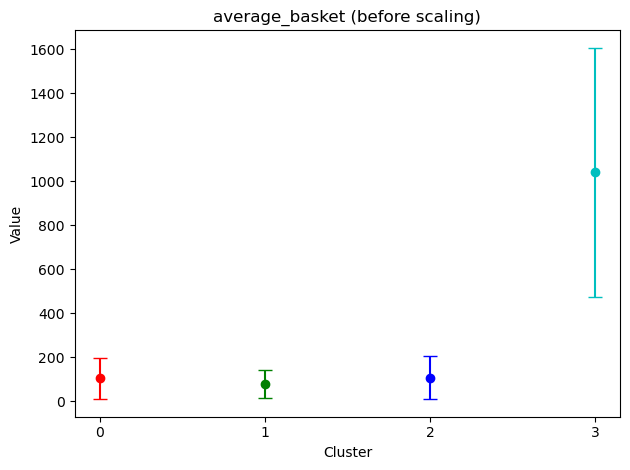

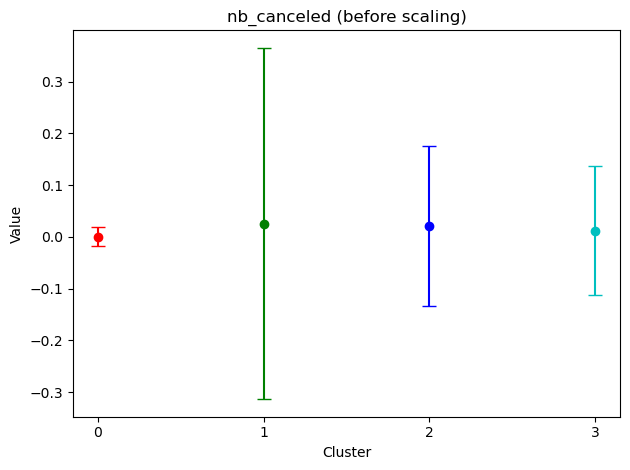

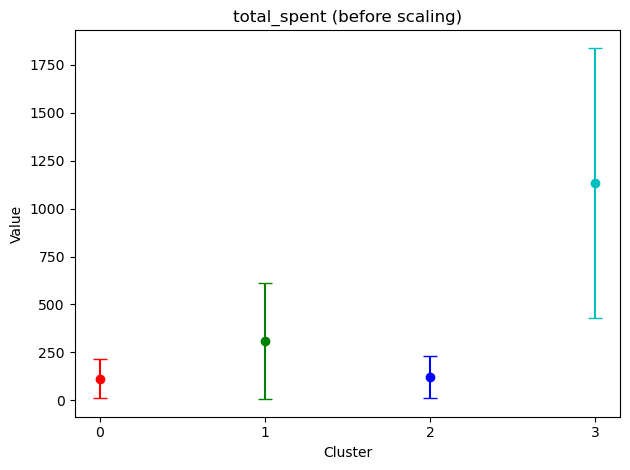

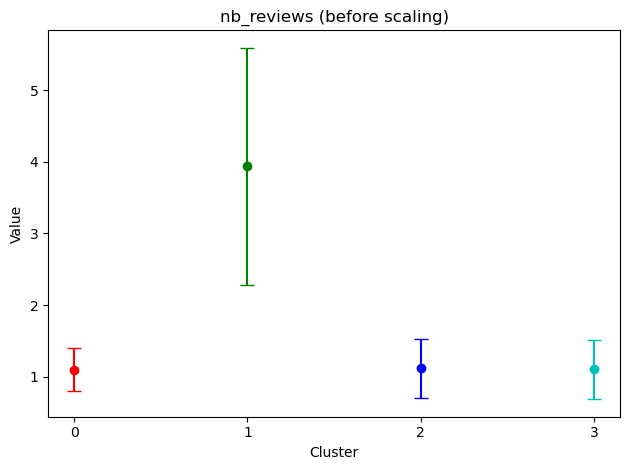

In [44]:
for feature in features:
    # Calculate cluster statistics for standard deviation and mean
    cluster_stats = raw_df.groupby('cluster').agg({feature: ['mean', 'std']})
    cluster_stats.columns = [f"{feature}_mean", f"{feature}_std"]

    # Create error bar plot with no lines between clusters and different colors
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # define colors for clusters
    for i, cluster in enumerate(cluster_stats.index):
        plt.errorbar(i, cluster_stats.loc[cluster, f"{feature}_mean"], yerr=cluster_stats.loc[cluster, f"{feature}_std"], capsize=5, color=colors[i%len(colors)], marker='o', linestyle='')

    plt.title(f'{feature} (before scaling)')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.xticks(range(len(cluster_stats)), cluster_stats.index) # set x ticks to cluster labels
    plt.tight_layout()
    plt.show()

## Kmeans v1_filtered

### Entraînement

#### Choix des features

In [45]:
features_v1_filtered = ['nb_orders', 'average_review_score', 'average_basket']

In [46]:
features = features_v1_filtered

#### Sélection du nombre de clusters

In [47]:
# Définir le nombre maximum de clusters à tester
n_clusters_max = 6

# Calculer les métriques pour chaque nombre de clusters
silhouette_scores = []
inertias = []
ch_scores = []

for i in range(2, n_clusters_max+1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df[features])

    # Silhouette Score
    silhouette_avg = silhouette_score(df[features], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Inertia
    inertias.append(kmeans.inertia_)

    # Calinski-Harabasz Score (variation inter-classe/intra-classe)
    ch_scores.append(calinski_harabasz_score(df[features], kmeans.labels_))

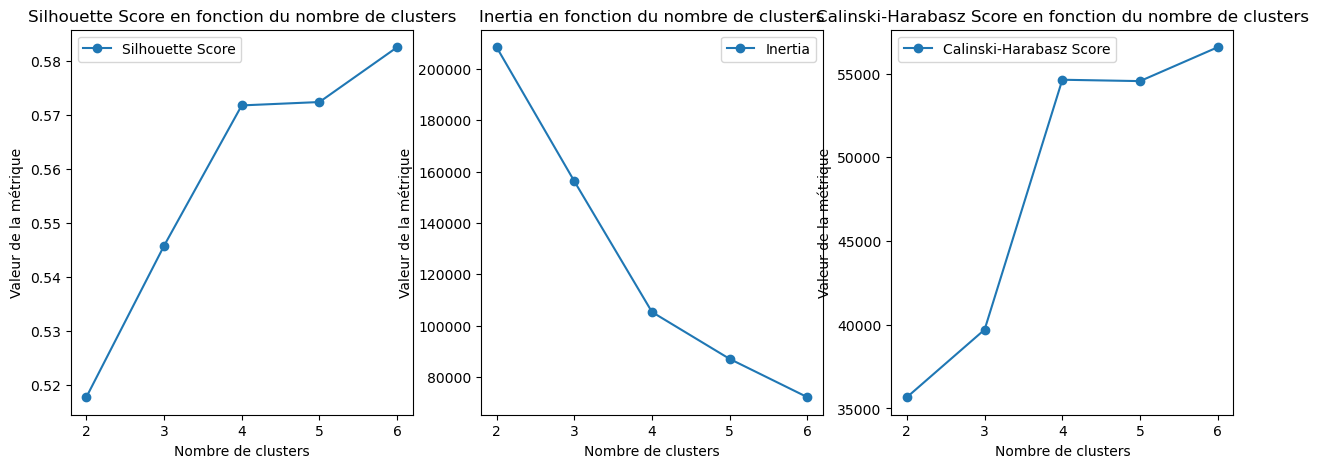

In [48]:
# Métriques et labels
metrics = [silhouette_scores, inertias, ch_scores]
labels = ['Silhouette Score', 'Inertia', 'Calinski-Harabasz Score']

# Créer une grille de sous-graphiques (1 ligne, 3 colonnes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Parcourir les métriques et les tracer côte à côte
for i, (metric, label, ax) in enumerate(zip(metrics, labels, axs)):
    ax.plot(range(2, n_clusters_max+1), metric, marker='o', label=label)
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Valeur de la métrique')
    ax.set_title(f'{label} en fonction du nombre de clusters')
    ax.legend()

plt.show()

On garde 4 clusters car on a déjà un très bon silhouette score et Calinski-Harabasz Score et observe un coude pour l'inertie.  
Je pense que 6 clusters ça fait trop pour catégoriser des clients. 4 me semble bien.

#### Entraînement final du modèle

In [46]:
# Select the number of clusters
n_clusters = 4

In [47]:
# Initialize the KMeans algorithm with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10)

# Fit the KMeans algorithm to the data
kmeans.fit(df[features])

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Calculate metrics
silhouette_avg = silhouette_score(df[features], df['cluster'])
inertia = kmeans.inertia_
ch_score = calinski_harabasz_score(df[features], df['cluster'])

# Print metrics
print(f'Silhouette Score: {silhouette_avg}') # > 0.5 = bon ; > 0.25 = ok ; < 0.25 = mauvais
print(f'Inertia: {inertia}') # Une valeur faible indique que les points dans chaque cluster sont proches les uns des autres (et donc que le clustering est efficace)
print(f'Calinski-Harabasz Score: {ch_score}') # Une valeur élevée indique que la variance entre les clusters est maximisée par rapport à la variance à l'intérieur des clusters, ce qui signifie que les clusters sont bien définis et distincts

Silhouette Score: 0.5716969966888428
Inertia: 105332.2890625
Calinski-Harabasz Score: 54630.90312100373


###  Evaluation

#### Nombre d'individus par cluster

In [48]:
df.groupby('cluster')['customer_unique_id'].count()

cluster
0    69353
1    20254
2     2505
3     3307
Name: customer_unique_id, dtype: int64

#### Ecart types et moyennes pour chaque variable

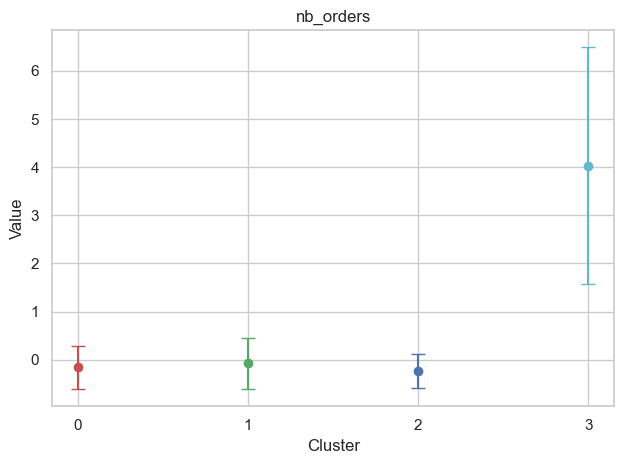

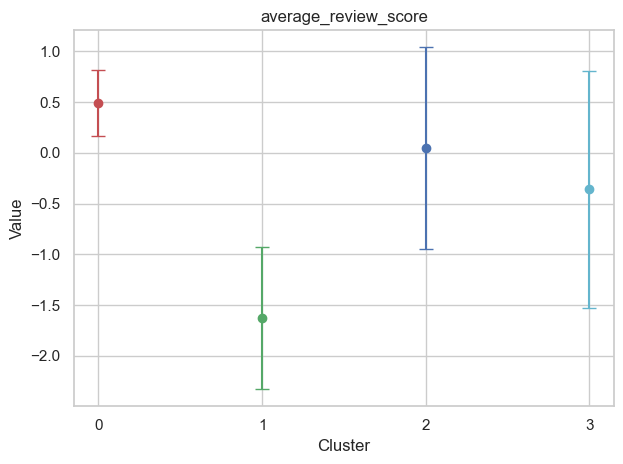

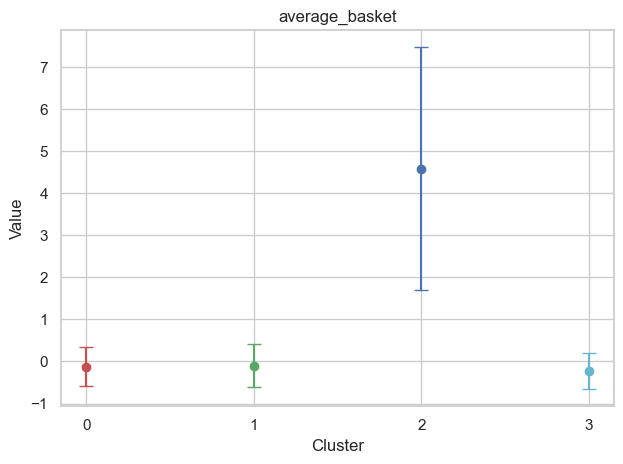

In [49]:
# Ecart type de toutes les variables. Si les clusters ont de trop gros écart types ça veut dire que la variable n'est pas utilisé dans le modèle de clustering 

for feature in features:
    # Calculate cluster statistics for standard deviation and mean
    cluster_stats = df.groupby('cluster').agg({feature: ['mean', 'std']})
    cluster_stats.columns = [f"{feature}_mean", f"{feature}_std"]

    # Create error bar plot with no lines between clusters and different colors
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # define colors for clusters
    for i, cluster in enumerate(cluster_stats.index):
        plt.errorbar(i, cluster_stats.loc[cluster, f"{feature}_mean"], yerr=cluster_stats.loc[cluster, f"{feature}_std"], capsize=5, color=colors[i%len(colors)], marker='o', linestyle='')

    plt.title(f'{feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.xticks(range(len(cluster_stats)), cluster_stats.index) # set x ticks to cluster labels
    plt.tight_layout()
    plt.show()

## Kmeans v2

### Entraînement

In [30]:
features_bonus = ['nb_articles_moyen_par_commande', 'nb_categories_moyen_par_commande', 'nb_mode_paiement', 'distance_to_warehouse', 'mode_de_paiement_majoritaire_boleto', 'mode_de_paiement_majoritaire_credit_card', 'mode_de_paiement_majoritaire_debit_card', 'mode_de_paiement_majoritaire_voucher']

In [31]:
features_v2 = features_v1_filtered + features_bonus

In [62]:
features = features_v2

In [63]:
# Définir le nombre maximum de clusters à tester
n_clusters_max = 6

# Calculer les métriques pour chaque nombre de clusters
silhouette_scores = []
inertias = []
ch_scores = []

for i in range(2, n_clusters_max+1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df[features])

    # Silhouette Score
    silhouette_avg = silhouette_score(df[features], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Inertia
    inertias.append(kmeans.inertia_)

    # Calinski-Harabasz Score (variation inter-classe/intra-classe)
    ch_scores.append(calinski_harabasz_score(df[features], kmeans.labels_))

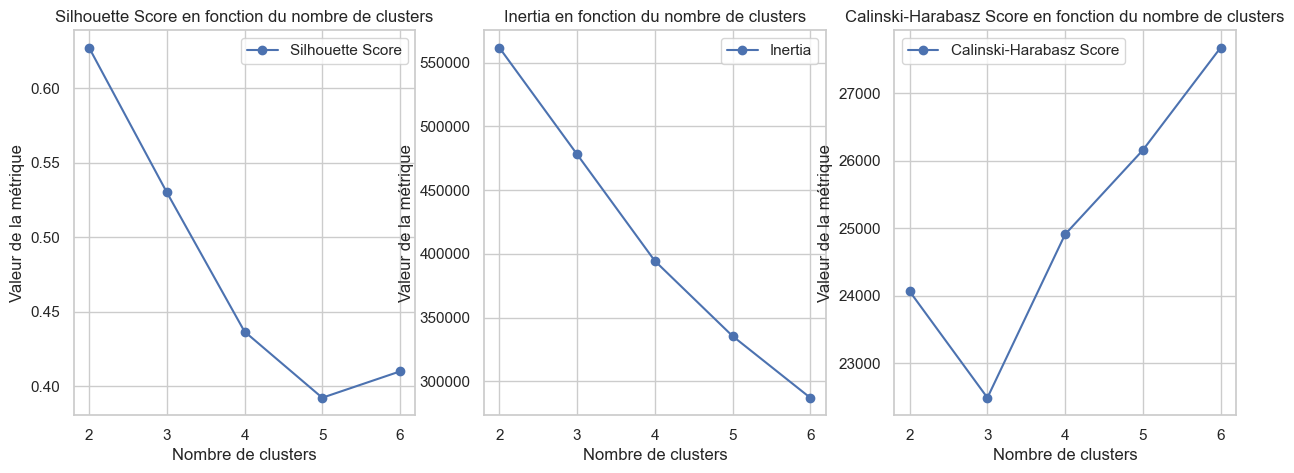

In [64]:
# Métriques et labels
metrics = [silhouette_scores, inertias, ch_scores]
labels = ['Silhouette Score', 'Inertia', 'Calinski-Harabasz Score']

# Créer une grille de sous-graphiques (1 ligne, 3 colonnes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Parcourir les métriques et les tracer côte à côte
for i, (metric, label, ax) in enumerate(zip(metrics, labels, axs)):
    ax.plot(range(2, n_clusters_max+1), metric, marker='o', label=label)
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Valeur de la métrique')
    ax.set_title(f'{label} en fonction du nombre de clusters')
    ax.legend()

plt.show()

Le silhouette score baisse en fonction du nombre de clusters, ce qui n'est pas bon.  
Il n'y a pas de coudes pour l'inertie.  
Le CH score augmente avec le nombre de cluster ce qui est bon.  

Je décide de conserver 4 clusters car d'un point de vue métier c'est ce qui me semble le plus juste, etc'est un bon équilibre entre le silhouette score et le CH score.

In [55]:
# Select the number of clusters
n_clusters = 4

In [56]:
# Initialize the KMeans algorithm with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10)

# Fit the KMeans algorithm to the data
kmeans.fit(df[features])

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Calculate metrics
silhouette_avg = silhouette_score(df[features], df['cluster'])
inertia = kmeans.inertia_
ch_score = calinski_harabasz_score(df[features], df['cluster'])

# Print metrics
print(f'Silhouette Score: {silhouette_avg}') # > 0.5 = bon ; > 0.25 = ok ; < 0.25 = mauvais
print(f'Inertia: {inertia}') # Une valeur faible indique que les points dans chaque cluster sont proches les uns des autres (et donc que le clustering est efficace)
print(f'Calinski-Harabasz Score: {ch_score}') # Une valeur élevée indique que la variance entre les clusters est maximisée par rapport à la variance à l'intérieur des clusters, ce qui signifie que les clusters sont bien définis et distincts

Silhouette Score: 0.44911259412765503
Inertia: 394445.53125
Calinski-Harabasz Score: 24916.975543951732


###  Evaluation

#### Nombre d'individus par cluster

In [57]:
df.groupby('cluster')['customer_unique_id'].count()

cluster
0    77170
1     4603
2     2113
3    11533
Name: customer_unique_id, dtype: int64

#### Ecart types et moyennes pour chaque variable

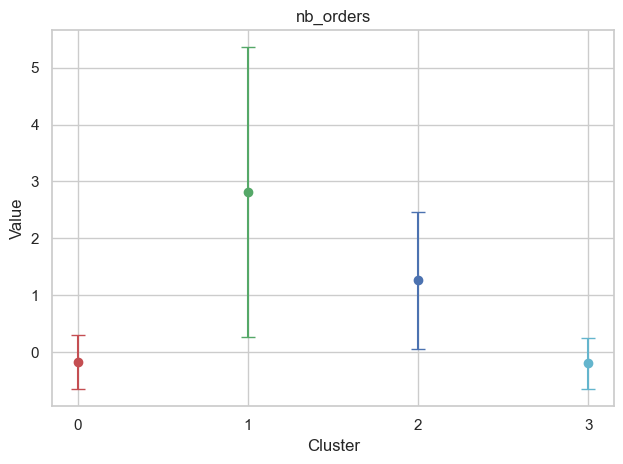

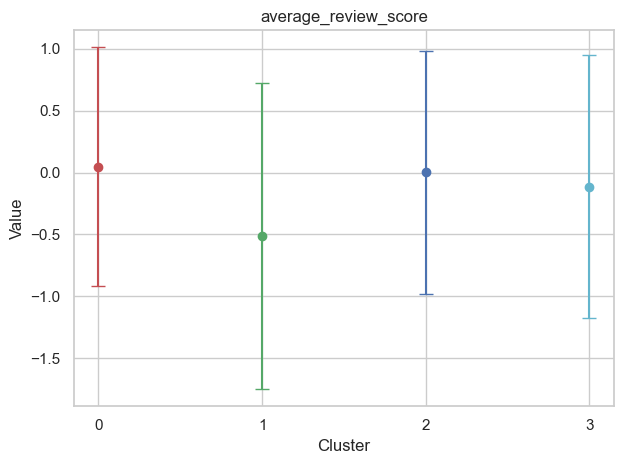

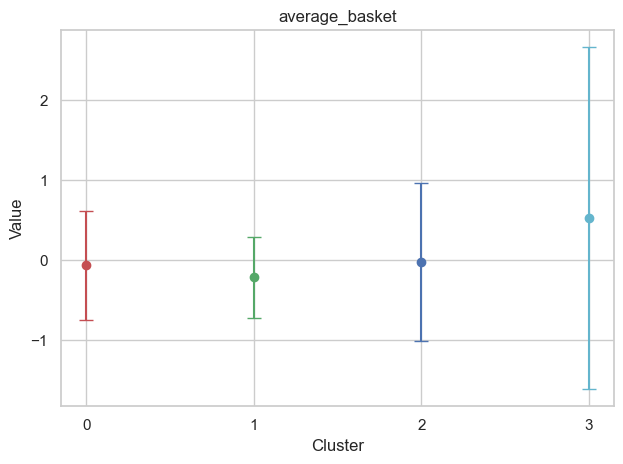

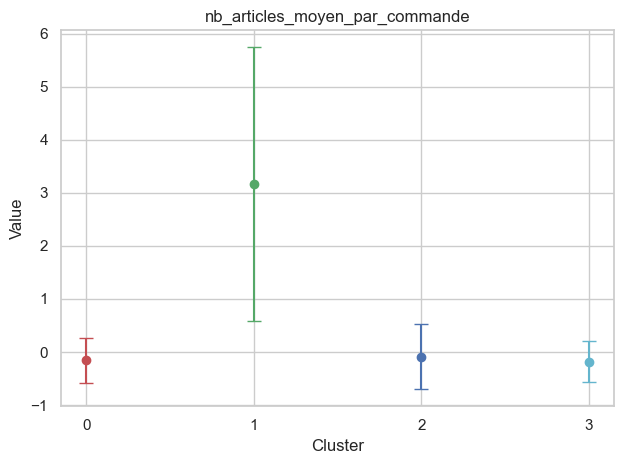

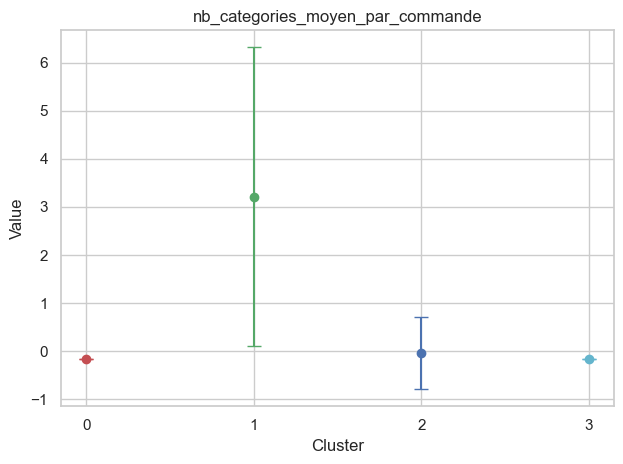

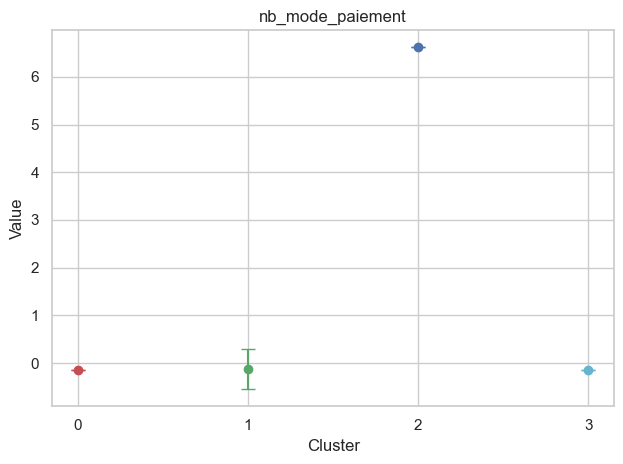

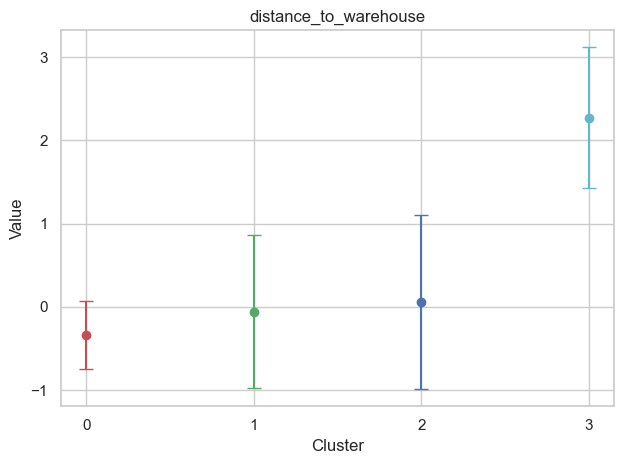

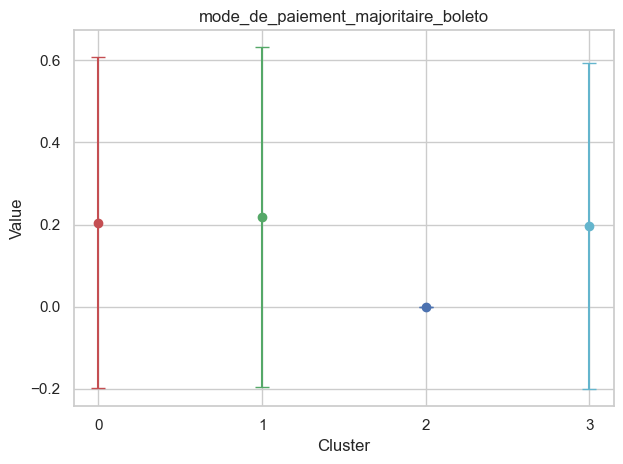

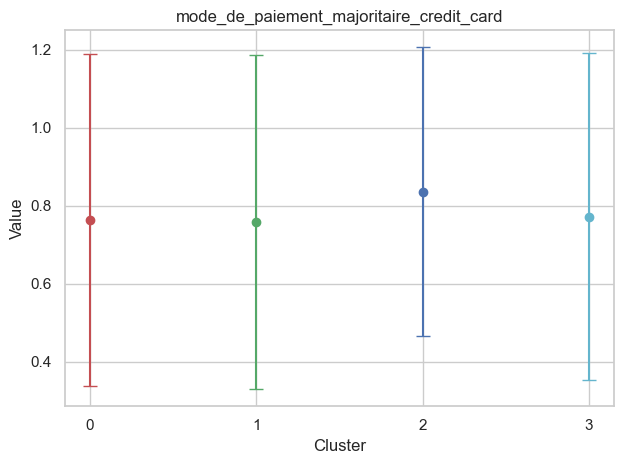

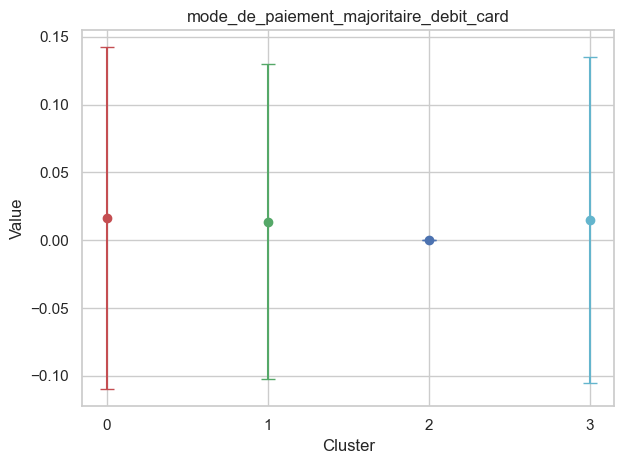

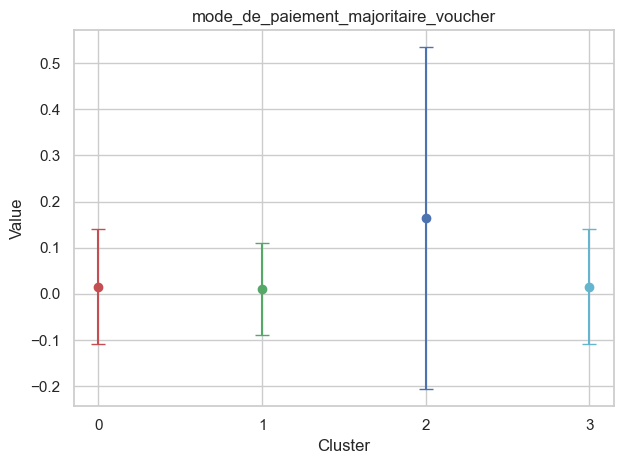

In [58]:
# Ecart type de toutes les variables. Si les clusters ont de trop gros écart types ça veut dire que la variable n'est pas utilisé dans le modèle de clustering 

for feature in features:
    # Calculate cluster statistics for standard deviation and mean
    cluster_stats = df.groupby('cluster').agg({feature: ['mean', 'std']})
    cluster_stats.columns = [f"{feature}_mean", f"{feature}_std"]

    # Create error bar plot with no lines between clusters and different colors
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # define colors for clusters
    for i, cluster in enumerate(cluster_stats.index):
        plt.errorbar(i, cluster_stats.loc[cluster, f"{feature}_mean"], yerr=cluster_stats.loc[cluster, f"{feature}_std"], capsize=5, color=colors[i%len(colors)], marker='o', linestyle='')

    plt.title(f'{feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.xticks(range(len(cluster_stats)), cluster_stats.index) # set x ticks to cluster labels
    plt.tight_layout()
    plt.show()

## Kmeans v2_filtered

### Entraînement

In [32]:
features_bonus_filtered = ['nb_articles_moyen_par_commande', 'distance_to_warehouse', 'nb_mode_paiement']

In [33]:
features_v2_filtered = features_v1_filtered + features_bonus_filtered

In [67]:
features = features_v2_filtered

In [68]:
# Select the number of clusters
n_clusters = 4

In [69]:
# Initialize the KMeans algorithm with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=18)

# Fit the KMeans algorithm to the data
kmeans.fit(df[features])

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Calculate metrics
silhouette_avg = silhouette_score(df[features], df['cluster'])
inertia = kmeans.inertia_
ch_score = calinski_harabasz_score(df[features], df['cluster'])

# Print metrics
print(f'Silhouette Score: {silhouette_avg}') # > 0.5 = bon ; > 0.25 = ok ; < 0.25 = mauvais
print(f'Inertia: {inertia}') # Une valeur faible indique que les points dans chaque cluster sont proches les uns des autres (et donc que le clustering est efficace)
print(f'Calinski-Harabasz Score: {ch_score}') # Une valeur élevée indique que la variance entre les clusters est maximisée par rapport à la variance à l'intérieur des clusters, ce qui signifie que les clusters sont bien définis et distincts

Silhouette Score: 0.4021892547607422
Inertia: 302447.3125
Calinski-Harabasz Score: 28400.331327179363


###  Evaluation

#### Nombre d'individus par cluster

In [70]:
df.groupby('cluster')['customer_unique_id'].count()

cluster
0    20528
1    70418
2     2120
3     2353
Name: customer_unique_id, dtype: int64

#### Ecart types et moyennes pour chaque variable

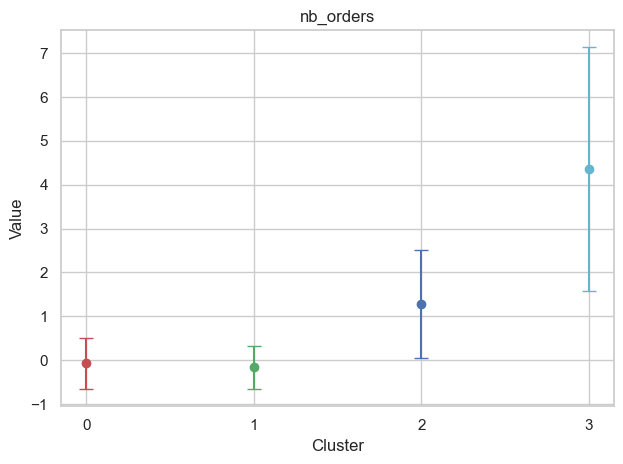

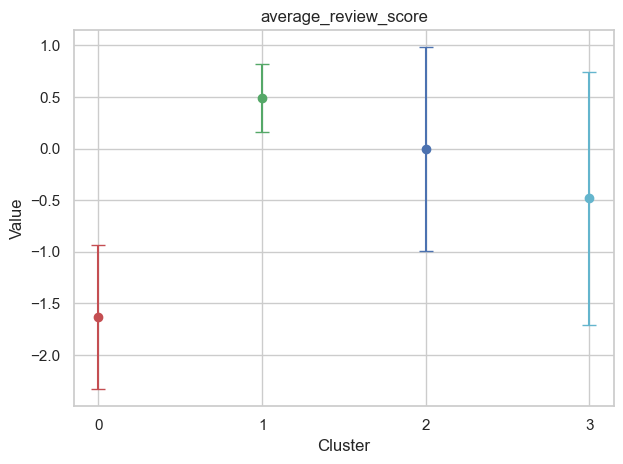

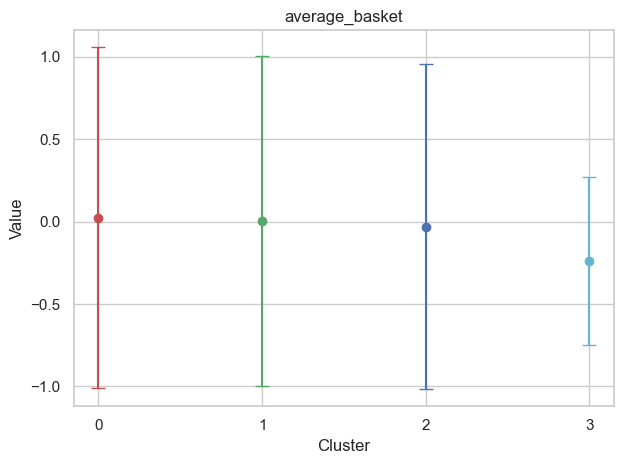

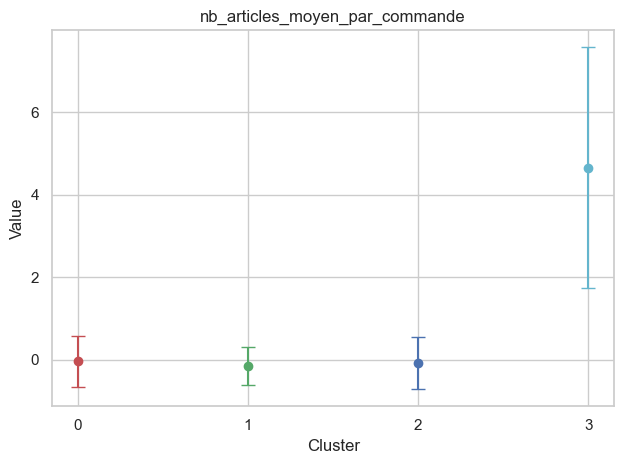

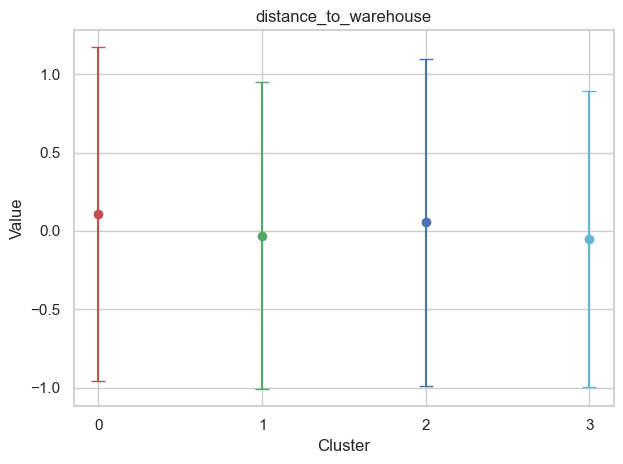

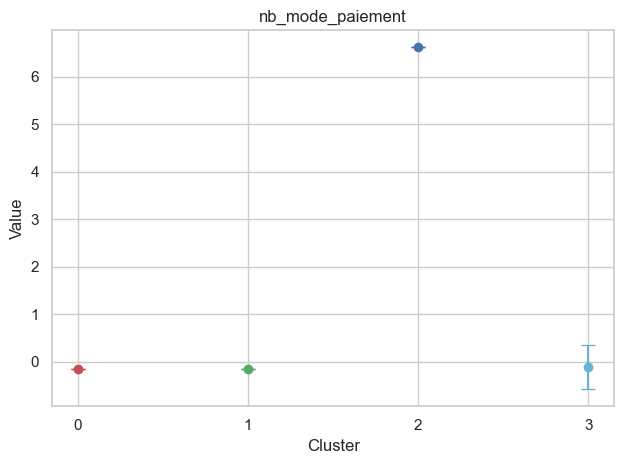

In [71]:
# Ecart type de toutes les variables. Si les clusters ont de trop gros écart types ça veut dire que la variable n'est pas utilisé dans le modèle de clustering 

for feature in features:
    # Calculate cluster statistics for standard deviation and mean
    cluster_stats = df.groupby('cluster').agg({feature: ['mean', 'std']})
    cluster_stats.columns = [f"{feature}_mean", f"{feature}_std"]

    # Create error bar plot with no lines between clusters and different colors
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # define colors for clusters
    for i, cluster in enumerate(cluster_stats.index):
        plt.errorbar(i, cluster_stats.loc[cluster, f"{feature}_mean"], yerr=cluster_stats.loc[cluster, f"{feature}_std"], capsize=5, color=colors[i%len(colors)], marker='o', linestyle='')

    plt.title(f'{feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.xticks(range(len(cluster_stats)), cluster_stats.index) # set x ticks to cluster labels
    plt.tight_layout()
    plt.show()

# Kmeans final

### Entraînement

In [34]:
features_bonus_validated = ['nb_articles_moyen_par_commande']

In [35]:
features_final = features_v1_filtered + features_bonus_validated

In [36]:
features = features_final

In [37]:
# Select the number of clusters
n_clusters = 4

In [42]:
# Initialize the KMeans algorithm with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=18)

# Fit the KMeans algorithm to the data
kmeans.fit(df[features])

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Calculate metrics
silhouette_avg = silhouette_score(df[features], df['cluster'])
inertia = kmeans.inertia_
ch_score = calinski_harabasz_score(df[features], df['cluster'])

# Print metrics
print(f'Silhouette Score: {silhouette_avg}') # > 0.5 = bon ; > 0.25 = ok ; < 0.25 = mauvais
print(f'Inertia: {inertia}') # Une valeur faible indique que les points dans chaque cluster sont proches les uns des autres (et donc que le clustering est efficace)
print(f'Calinski-Harabasz Score: {ch_score}') # Une valeur élevée indique que la variance entre les clusters est maximisée par rapport à la variance à l'intérieur des clusters, ce qui signifie que les clusters sont bien définis et distincts

Silhouette Score: 0.5413916110992432
Inertia: 154583.25
Calinski-Harabasz Score: 46723.4221426489


###  Evaluation

#### Nombre d'individus par cluster

In [43]:
df.groupby('cluster')['customer_unique_id'].count()

cluster
0    69945
1    20445
2     2526
3     2503
Name: customer_unique_id, dtype: int64

#### Ecart types et moyennes pour chaque variable

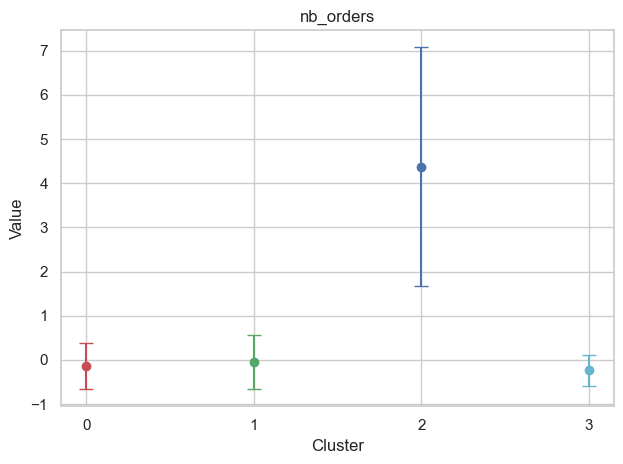

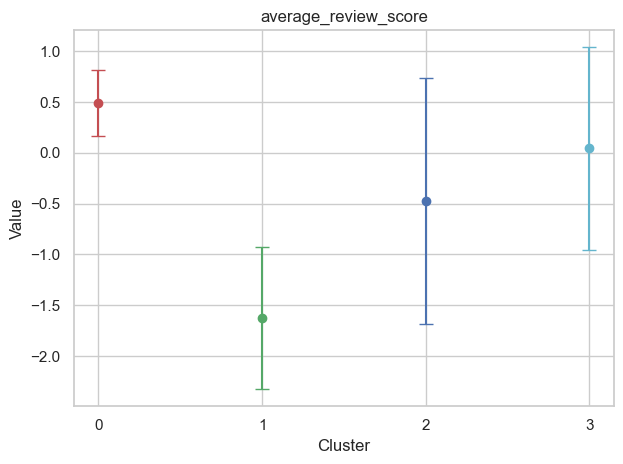

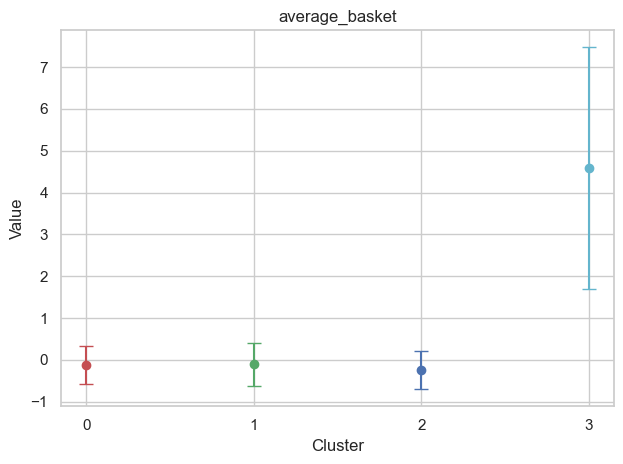

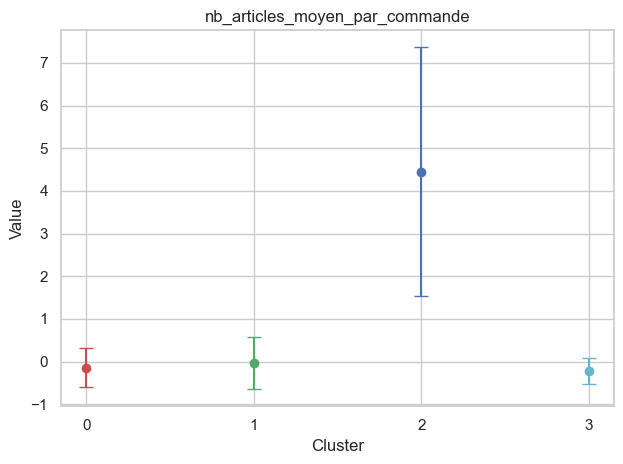

In [44]:
# Ecart type de toutes les variables. Si les clusters ont de trop gros écart types ça veut dire que la variable n'est pas utilisé dans le modèle de clustering 

for feature in features:
    # Calculate cluster statistics for standard deviation and mean
    cluster_stats = df.groupby('cluster').agg({feature: ['mean', 'std']})
    cluster_stats.columns = [f"{feature}_mean", f"{feature}_std"]

    # Create error bar plot with no lines between clusters and different colors
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # define colors for clusters
    for i, cluster in enumerate(cluster_stats.index):
        plt.errorbar(i, cluster_stats.loc[cluster, f"{feature}_mean"], yerr=cluster_stats.loc[cluster, f"{feature}_std"], capsize=5, color=colors[i%len(colors)], marker='o', linestyle='')

    plt.title(f'{feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.xticks(range(len(cluster_stats)), cluster_stats.index) # set x ticks to cluster labels
    plt.tight_layout()
    plt.show()

# Annexes

#### TSNE (alternative de l'ACP quand valeurs pas linéaire) - Annexe

In [28]:
# Réduire les dimensions à l'aide de t-SNE
tsne = TSNE(n_components=2, random_state=42)
df_2d = tsne.fit_transform(df[features])

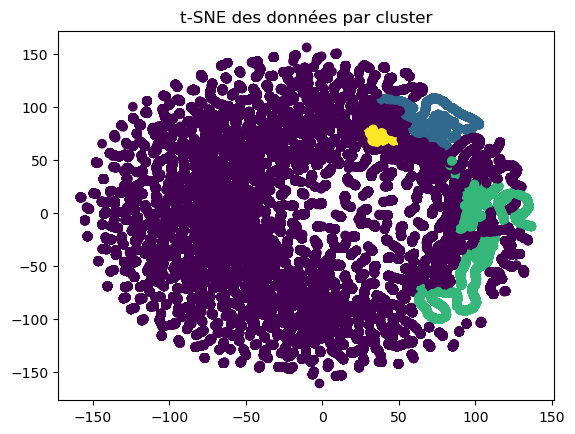

In [29]:
# Créer un scatter plot des données réduites en 2 dimensions
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=df['cluster'])
plt.title('t-SNE des données par cluster')
plt.show()

#### ACP - Annexe

In [24]:
# Apply PCA to the features and keep the first three principal components
n_components = df[features].shape[1]
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(df[features])

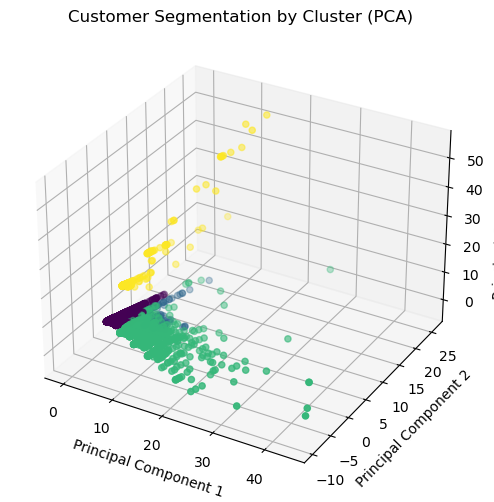

In [25]:
# Permet de déterminer visuellement si le nombre de clusters est approprié
# Create a 3D scatter plot of the first three principal components colored by cluster
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=df['cluster'], cmap='viridis')
ax.set_title('Customer Segmentation by Cluster (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

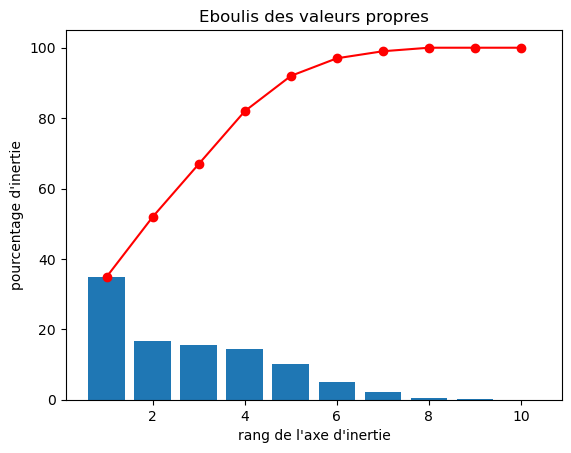

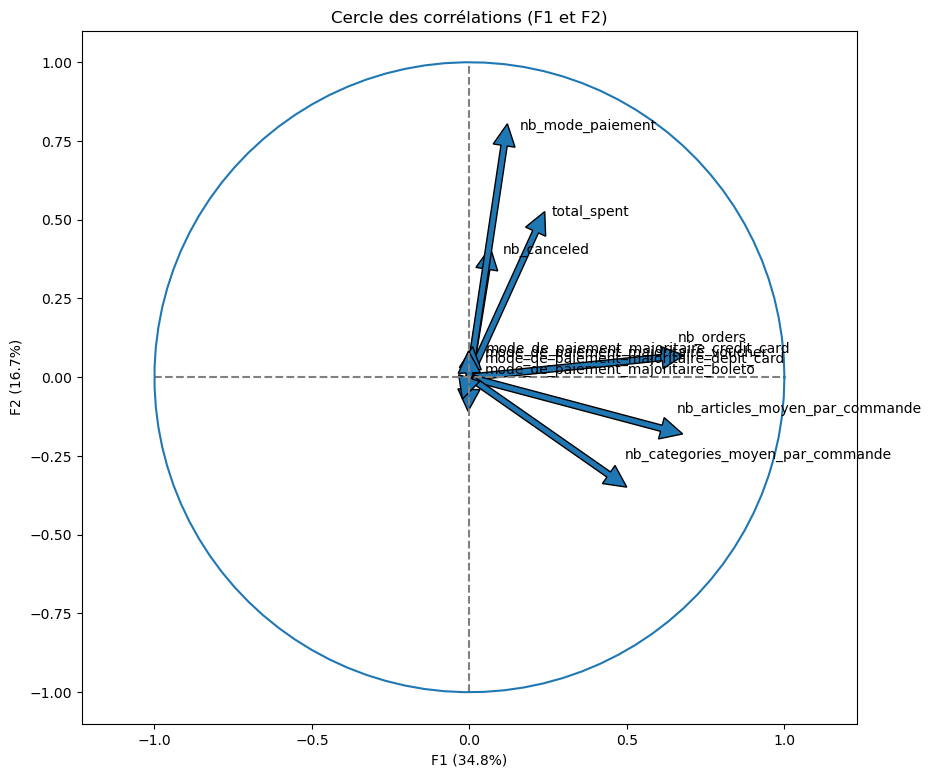

In [26]:
x = 0
y = 1

scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum().round()

x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)


fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

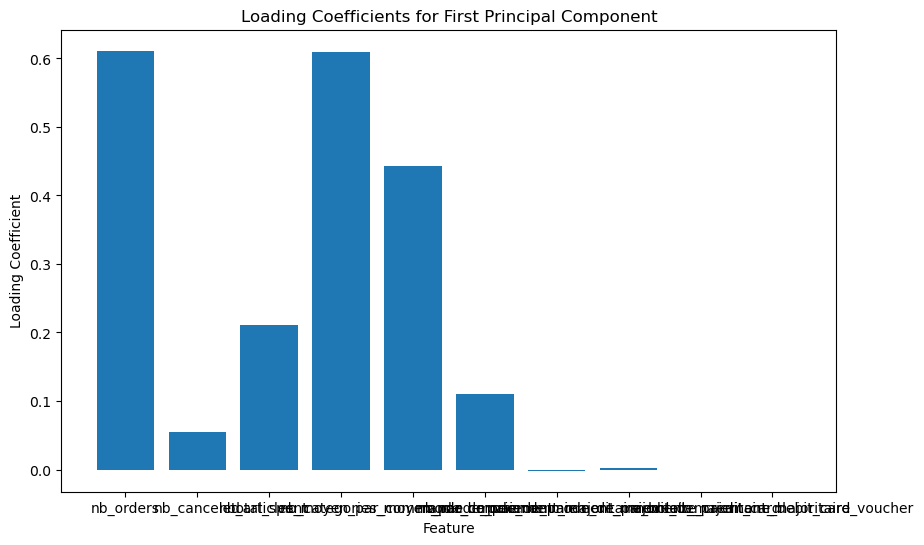

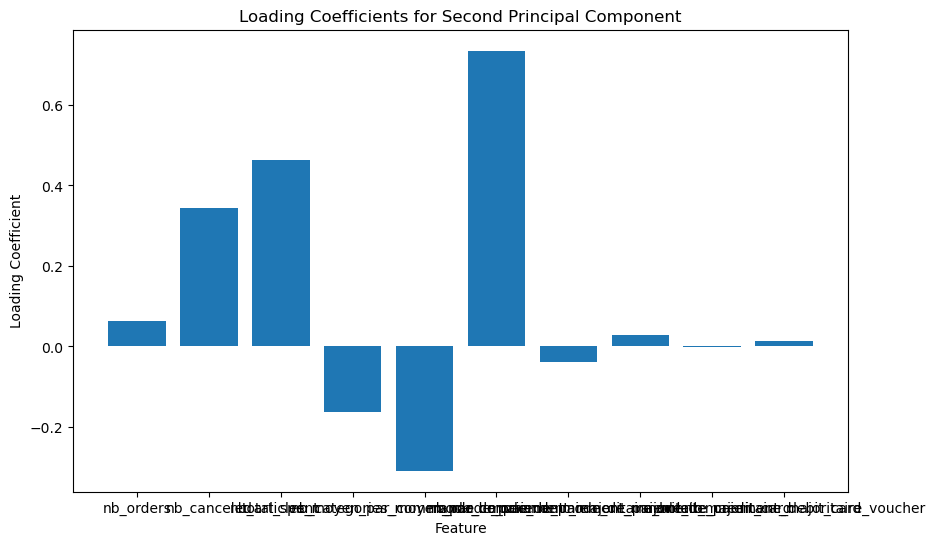

In [27]:
# Explique quelles variables participent à la création de l'axe 1 et 2 (Coefficient -> 0 : Ne participe pas ; -> 1 : participe)

# Calculate the loading coefficients for the first two principal components
loadings = pca.components_[:2]

# Create a bar plot of the loading coefficients for the first principal component
plt.figure(figsize=(10, 6))
plt.bar(df[features].columns, loadings[0])
plt.title('Loading Coefficients for First Principal Component')
plt.xlabel('Feature')
plt.ylabel('Loading Coefficient')
plt.show()

# Create a bar plot of the loading coefficients for the second principal component
plt.figure(figsize=(10, 6))
plt.bar(df[features].columns, loadings[1])
plt.title('Loading Coefficients for Second Principal Component')
plt.xlabel('Feature')
plt.ylabel('Loading Coefficient')
plt.show()

# /!\ Attention, les var qui composent l'axe (valeur absolue du coefficient directeur élevée et loin de 0) ne signifie pas forcément que l'algo de clusterisation a utiliser les mêmes variables, à tester.
# Cela signifie que l'ACP les a utilisé, mais c'est pas le même algo. Ca peut donner une indication mais pas de réelle info.

# Exploration

In [7]:
data.dtypes

customer_unique_id       object
seniority               float64
nb_reviews                int64
average_review_score    float64
nb_orders                 int64
average_basket          float64
nb_canceled               int64
dtype: object

In [ ]:
data.describe()

In [ ]:
data.head()

In [8]:
data.isnull().describe()

,customer_unique_id,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled
count,95420,95420,95420,95420,95420,95420,95420
unique,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False
freq,95420,95420,95420,94721,95420,95420,95420


In [7]:
data['customer_unique_id'].describe()

count                                95419
unique                               95419
top       0000366f3b9a7992bf8c76cfdf3221e2
freq                                     1
Name: customer_unique_id, dtype: object

In [9]:
data[data['average_review_score'].isnull()].describe()

,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled
count,699.000000,699.0,0.0,699.000000,699.000000,699.000000
mean,310.968092,0.0,NaN,1.271817,150.045947,0.021459
std,150.480681,0.0,NaN,1.003115,324.571346,0.145013
min,50.290475,0.0,NaN,1.000000,5.000000,0.000000
25%,197.377795,0.0,NaN,1.000000,44.995000,0.000000
50%,293.203762,0.0,NaN,1.000000,82.400000,0.000000
75%,417.122083,0.0,NaN,1.000000,150.000000,0.000000
max,741.293403,0.0,NaN,20.000000,6729.000000,1.000000


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


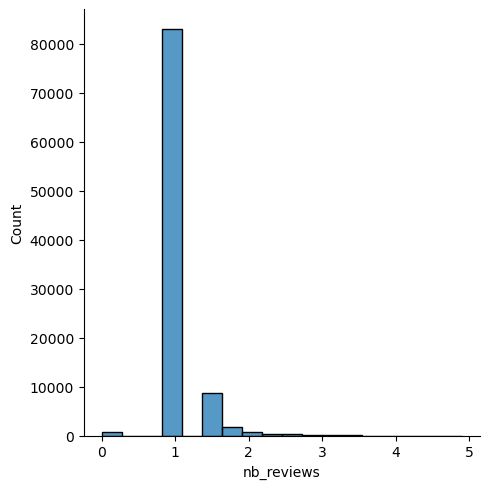

In [15]:
sns.displot(np.sqrt(df['nb_reviews']))

In [35]:
data.groupby('customer_state')['avg_freight_value'].describe()

,count,mean,std,min,25%,50%,75%,max
customer_state,,,,,,,,
AC,77.0,41.699740,17.487356,21.41,27.4000,38.080,52.16000,108.36
AL,399.0,36.163446,23.552608,0.00,22.8500,32.990,42.38000,314.40
AM,142.0,33.277007,19.564977,17.50,24.3500,26.520,34.15000,165.75
AP,67.0,34.951642,20.152701,0.00,23.3400,29.940,39.20500,133.39
BA,3257.0,26.247958,18.960660,0.00,17.3400,20.870,27.08000,284.60
CE,1304.0,33.086171,22.937610,0.00,20.7400,27.030,37.22250,250.57
DF,2061.0,21.380332,15.477194,0.00,15.2300,17.250,21.88000,294.76
ES,1955.0,22.172758,15.720382,0.00,15.7200,18.110,21.99000,321.88
GO,1941.0,23.031006,15.911451,0.00,15.7900,18.150,22.93000,174.95


In [37]:
data['customer_state'].unique()

array(['SP', 'SC', 'PA', 'PR', 'RJ', 'MA', 'ES', 'RS', 'MG', 'GO', 'DF',
       'BA', 'MT', 'SE', 'TO', 'PE', 'CE', 'AL', 'AC', 'PI', 'PB', 'RN',
       'AM', 'MS', 'RR', 'AP', 'RO'], dtype=object)

In [31]:
transformed_df.head()

,customer_unique_id,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,customer_state,mode_de_paiement_majoritaire,nb_mode_paiement,avg_freight_value,total_spent,distance_to_warehouse
0,0000366f3b9a7992bf8c76cfdf3221e2,159.544128,1,5.0,1,129.899994,0,1.0,1.0,SP,credit_card,1,12.000000,129.899994,350
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162.533722,1,4.0,1,18.900000,0,1.0,1.0,SP,credit_card,1,8.290000,18.900000,350
2,0000f46a3911fa3c0805444483337064,585.121521,1,3.0,1,69.000000,0,1.0,1.0,SC,credit_card,1,17.219999,69.000000,250
3,0000f6ccb0745a6a4b88665a16c9f078,369.146057,1,4.0,1,25.990000,0,1.0,1.0,PA,credit_card,1,17.629999,25.990000,3000
4,0004aac84e0df4da2b147fca70cf8255,336.176605,1,5.0,1,180.000000,0,1.0,1.0,SP,credit_card,1,16.889999,180.000000,350


In [32]:
data.head()

,customer_unique_id,seniority,nb_reviews,average_review_score,nb_orders,average_basket,nb_canceled,nb_articles_moyen_par_commande,nb_categories_moyen_par_commande,customer_state,mode_de_paiement_majoritaire,nb_mode_paiement,avg_freight_value
0,0000366f3b9a7992bf8c76cfdf3221e2,159.544132,1,5.0,1,129.90,0,1.0,1.0,SP,credit_card,1,12.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162.533715,1,4.0,1,18.90,0,1.0,1.0,SP,credit_card,1,8.29
2,0000f46a3911fa3c0805444483337064,585.121493,1,3.0,1,69.00,0,1.0,1.0,SC,credit_card,1,17.22
3,0000f6ccb0745a6a4b88665a16c9f078,369.146053,1,4.0,1,25.99,0,1.0,1.0,PA,credit_card,1,17.63
4,0004aac84e0df4da2b147fca70cf8255,336.176597,1,5.0,1,180.00,0,1.0,1.0,SP,credit_card,1,16.89
